# Towards Automated Stubble Burning Detection using Satellite Image Segmentation

## The Vital Role of Image Segmentation in Environmental Monitoring

**Image Segmentation** is a fundamental computer vision technique that involves partitioning a digital image into multiple distinct regions or segments. Instead of just classifying an entire image (e.g., "this image contains a fire"), segmentation assigns a specific class label (like "burned area", "unburned vegetation", "water", "soil") to **each individual pixel**.

This pixel-level understanding is crucial for environmental monitoring using satellite remote sensing data for several reasons:

1.  **Precise Spatial Quantification:** Segmentation allows us to accurately measure the *area* and delineate the exact *boundaries* of environmental features or events, such as deforestation, urban sprawl, flood inundation, or, critically for this project, burned areas.
2.  **Detailed Mapping:** It transforms raw satellite imagery into informative maps that clearly show the spatial distribution and extent of different land cover types or phenomena.
3.  **Change Detection:** By comparing segmented maps from different time points, we can precisely track changes in the environment, such as the spread of a fire, the recovery of vegetation post-fire, or the seasonal patterns of agricultural practices.
4.  **Targeted Analysis:** Knowing the exact location and extent of an event allows for focused analysis, such as assessing the severity of a burn within specific boundaries or estimating emissions from identified burned areas.

For applications like fire monitoring, segmentation moves beyond simple detection ("is there a fire?") to provide actionable insights ("where exactly is the fire, how large is it, and what areas are affected?").

## Current Work: Forest Fire Segmentation with Enhanced Inputs

Our current project focuses on developing an automated system for segmenting burned areas resulting from **forest fires**. We are utilizing:

* **Dataset:** The CEMS (Copernicus Emergency Management Service) Wildfires dataset (`links-ads/wildfires-cems`), which contains Sentinel-2 satellite images paired with manually delineated masks of burned areas from various forest fire events.
* **Model:** A semantic segmentation model (currently configured with SegFormer architecture).
* **Key Improvement - Spectral Indices:** To enhance the model's ability to distinguish burned areas from spectrally similar features (like bare soil, shadows, or different types of unburned vegetation), we are incorporating **spectral indices** as additional input channels alongside the raw Sentinel-2 bands. Specifically:
    * **Normalized Burn Ratio (NBR):** Calculated as `(NIR - SWIR) / (NIR + SWIR)`. NBR is highly sensitive to changes caused by fire. Healthy vegetation has high NIR and low SWIR reflectance, resulting in a high NBR. Burned areas exhibit lower NIR and higher SWIR reflectance, leading to a significantly lower NBR. This index is a standard and effective tool for highlighting burned areas.
    * **Normalized Difference Vegetation Index (NDVI):** Calculated as `(NIR - Red) / (NIR + Red)`. NDVI is a strong indicator of vegetation health and density. While less direct for burn *severity* than NBR, it provides crucial context about the pre-burn vegetation state and helps differentiate vegetated areas from non-vegetated ones, which can improve overall segmentation accuracy.

By feeding the model not just the raw spectral data but also these derived indices, we provide it with more explicit, distilled information directly relevant to identifying burned vegetation, aiming for a more robust and accurate segmentation performance on forest fires.

## Future Goal: Segmentation of Stubble Burning Events

While forest fires are a significant environmental concern, another critical issue, particularly relevant seasonally in agricultural regions like Punjab (Pakistan and India), is **stubble burning** (the burning of crop residue after harvest). This practice contributes significantly to air pollution, impacting human health and regional climate, and affects soil fertility.

Our future goal is to adapt and apply our image segmentation techniques to specifically **detect and map areas affected by stubble burning** using satellite imagery. This requires distinguishing burned agricultural fields from unburned fields, harvested fields, other types of fires, and surrounding land cover.

## Methodology: Transfer Learning / Fine-tuning

Instead of training a model from scratch for stubble burning, which would require a large, specifically labeled dataset, we plan to leverage our work on the forest fire dataset using **Transfer Learning** and **Fine-tuning**:

1.  **Leverage Pre-trained Knowledge:** The model trained on the CEMS forest fire dataset has already learned valuable features for identifying burned biomass, thermal anomalies, and distinguishing textures associated with fire effects from Sentinel-2 data. These learned features (especially in the earlier layers of the neural network) are likely applicable to stubble burning as well, since both involve the combustion of vegetation.
2.  **Adaptation:** We will take the model pre-trained on forest fires and fine-tune it on a new dataset specifically containing examples of stubble burning events (images and corresponding masks).
3.  **Fine-tuning Process:** This typically involves:
    * Replacing the final classification layer if necessary (though likely still binary burn/no-burn).
    * Initializing the model with the weights learned from the forest fire task.
    * Retraining the model on the stubble burning dataset, often using a lower learning rate. We might initially freeze the weights of the earliest layers (which learned general features) and only train the later layers, or unfreeze all layers for end-to-end fine-tuning.

**Why Transfer Learning?**

* **Data Efficiency:** It significantly reduces the amount of labeled data needed for the new stubble burning task, as the model already has a strong starting point.
* **Time Efficiency:** Fine-tuning is generally much faster than training a deep learning model from scratch.
* **Performance:** Often leads to better performance on the target task compared to training from scratch, especially with limited target-domain data, by leveraging the robust features learned on the larger source dataset.

In [1]:
print("Installing necessary packages...")
!pip install rasterio segmentation-models-pytorch tqdm matplotlib seaborn tqdm transformers albumentations

import os
import subprocess
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.transforms import functional as F
import segmentation_models_pytorch as smp
from tqdm.notebook import tqdm
from PIL import Image
import random
import glob
import rasterio
import time
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from tqdm.notebook import tqdm
import random
import segmentation_models_pytorch as smp
import torch.optim as optim
import torch.nn as nn
import time
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2

print("Installing and configuring Git LFS...")
!sudo apt-get update -qq
!sudo apt-get install -y -qq git-lfs
!git lfs install --system --skip-repo

repo_url = "https://huggingface.co/datasets/links-ads/wildfires-cems"
repo_dir = "wildfires-cems"
data_dir = os.path.join(repo_dir, "data")


if not os.path.exists(repo_dir):
    print(f"Cloning repository: {repo_url}")

    !GIT_LFS_SKIP_SMUDGE=1 git clone {repo_url}
    print("Repository structure cloned.")
else:
    print(f"Directory {repo_dir} already exists. Skipping clone.")


os.chdir(repo_dir)
print(f"Current directory: {os.getcwd()}")
print("Pulling LFS files...")
!git lfs pull
print("LFS files pulled.")
os.chdir("..")
print(f"Current directory: {os.getcwd()}")



extracted_train_dir = os.path.join(data_dir, "train")
extracted_val_dir = os.path.join(data_dir, "val")
extracted_test_dir = os.path.join(data_dir, "test")



check_extraction_indicator = os.path.join(extracted_train_dir, "EMSR647")

if not os.path.exists(check_extraction_indicator):
    print("Extracting Training Data...")

    os.makedirs(extracted_train_dir, exist_ok=True)
    train_cmd = f"cat {data_dir}/train/train.tar.* | tar -xzvf - -i -C {extracted_train_dir}"
    print(f"Running: {train_cmd}")
    subprocess.run(train_cmd, shell=True, check=True)
    print("Training data extracted.")

    print("Extracting Validation Data...")
    os.makedirs(extracted_val_dir, exist_ok=True)
    val_cmd = f"cat {data_dir}/val/val.tar.* | tar -xzvf - -i -C {extracted_val_dir}"
    print(f"Running: {val_cmd}")
    subprocess.run(val_cmd, shell=True, check=True)
    print("Validation data extracted.")


    print("Extracting Test Data...")
    os.makedirs(extracted_test_dir, exist_ok=True)
    test_cmd = f"cat {data_dir}/test/test.tar.* | tar -xzvf - -i -C {extracted_test_dir}"
    print(f"Running: {test_cmd}")
    subprocess.run(test_cmd, shell=True, check=True)
    print("Test data extracted.")
else:
     print("Data appears to be already extracted. Skipping extraction.")

print("Data preparation finished.")


Installing necessary packages...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 57.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 KB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 97.6 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 104.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 KB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 KB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 KB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 KB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 119.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 KB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6

# 2. Exploratory Data Analysis (EDA)

This section focuses on understanding the dataset's characteristics through visualization and statistical analysis.

* **Setup:**
    * Defines base paths for accessing the extracted data specifically for EDA.
    * Sets constants for analysis:
        * `RGB_BANDS_ZERO_BASED`: Specifies the indices (0-based) for Red, Green, Blue bands (e.g., B4, B3, B2) used for visualization.
        * `SELECTED_BANDS_ZERO_BASED_EDA`: Lists the indices of bands selected for analysis (should match training bands).
        * `S2_NORMALIZATION_FACTOR_EDA`: Defines the scaling factor (10000.0) for Sentinel-2 reflectance values.
        * `N_SAMPLES_EDA`: Sets the number of random samples to analyze.
    * Finds all training image files (`*_S2L2A.tif`) recursively within the training directory.
    * Randomly selects `N_SAMPLES_EDA` image files for analysis. Includes error handling if no files are found.
* **Function Definitions:**
    * `plot_image_mask_pair`: Loads a Sentinel-2 image and its corresponding delineation mask. It displays the image as an RGB composite (using a **percentile stretch** visualization to handle brightness variations and avoid black images) alongside its binary mask.
    * `analyze_pixel_distributions`: Reads selected bands from sample images, collects pixel values (excluding potential NoData=0), and plots histograms showing the distribution of reflectance values overall and per selected band before normalization. Uses a log scale for frequency to better visualize distributions.
    * `analyze_class_balance`: Reads mask files corresponding to sample images, calculates the percentage of burned pixels (value=1) in each mask, and plots a histogram showing the distribution of these percentages across the samples. Also calculates the overall dataset balance.
    * `check_dimensions_nodata`: Reads sample images to check their dimensions (height, width) and the NoData value specified in the metadata (checks the first band). Reports the frequency of different shapes and NoData values found.
* **Execution:**
    * Checks if sample files were successfully found.
    * If samples exist:
        * Visualizes the first few sample image/mask pairs using `plot_image_mask_pair`.
        * Runs the analysis functions (`analyze_pixel_distributions`, `analyze_class_balance`, `check_dimensions_nodata`) on the selected samples.
    * If no samples were found, skips the EDA functions.



--- Starting Exploratory Data Analysis (EDA) ---
Found 281 training images. Analyzing 15 samples.

--- Visualizing Sample Image/Mask Pairs ---


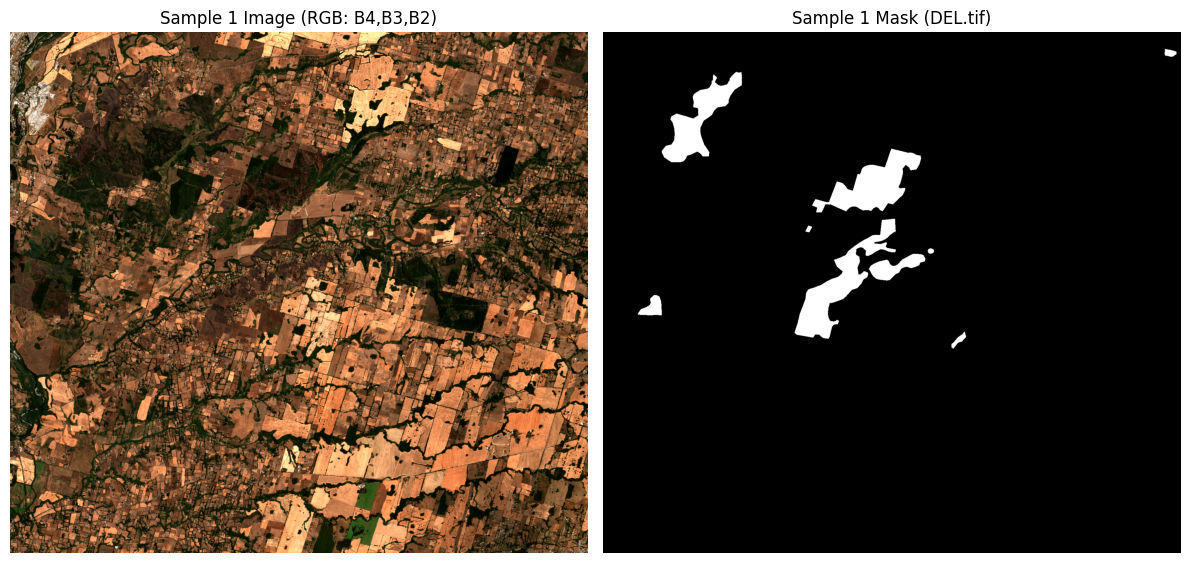

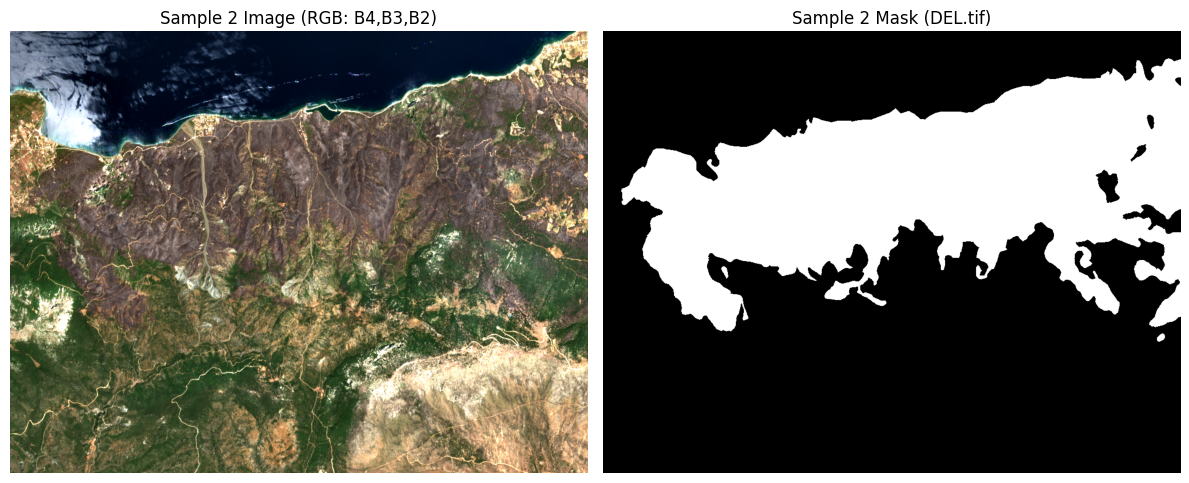

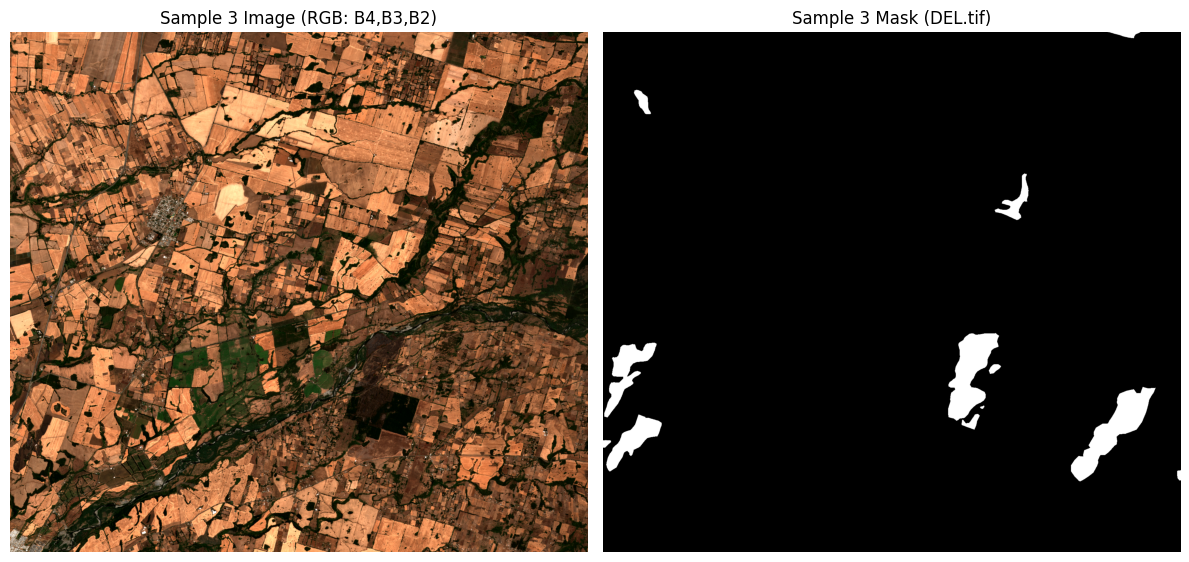

In [2]:
print("--- Starting Exploratory Data Analysis (EDA) ---")
BASE_DATA_DIR_EDA = "wildfires-cems"
EXTRACTED_TRAIN_DIR_EDA = os.path.join(BASE_DATA_DIR_EDA, "data", "train")
EXTRACTED_VAL_DIR_EDA = os.path.join(BASE_DATA_DIR_EDA, "data", "val")

RGB_BANDS_ZERO_BASED = [3, 2, 1]

SELECTED_BANDS_ZERO_BASED_EDA = [1, 2, 3, 7, 10, 11]
S2_NORMALIZATION_FACTOR_EDA = 10000.0
N_SAMPLES_EDA = 15

try:
    train_image_files_eda = glob.glob(os.path.join(EXTRACTED_TRAIN_DIR_EDA, "**", "*_S2L2A.tif"), recursive=True)
    if not train_image_files_eda:
        raise FileNotFoundError(f"No training '*_S2L2A.tif' files found in {EXTRACTED_TRAIN_DIR_EDA}")
    N_SAMPLES_EDA = min(N_SAMPLES_EDA, len(train_image_files_eda))
    sample_files_eda = random.sample(train_image_files_eda, N_SAMPLES_EDA)
    print(f"Found {len(train_image_files_eda)} training images. Analyzing {N_SAMPLES_EDA} samples.")
except FileNotFoundError as e:
    print(f"EDA Error: {e}. Please ensure Cell 1 ran correctly and data is extracted.")
    sample_files_eda = []
    
def plot_image_mask_pair(img_path, mask_path, rgb_bands_indices, title_prefix=""):

    S2_NORMALIZATION_FACTOR_EDA = 10000.0

    try:
        with rasterio.open(img_path) as src:
            if max(rgb_bands_indices) >= src.count:
                 print(f"Warning: Not enough bands for RGB in {img_path}. Requested max index {max(rgb_bands_indices)}, Available: {src.count-1}")
                 return
            img_rgb = src.read([b + 1 for b in rgb_bands_indices]).astype(np.float32)

        with rasterio.open(mask_path) as src:
            mask = src.read(1)

        img_rgb /= S2_NORMALIZATION_FACTOR_EDA

        valid_pixels = img_rgb[img_rgb > 0]
        if valid_pixels.size == 0:
             p_low, p_high = 0.0, 1.0
        else:
             p_low, p_high = np.percentile(valid_pixels, [2, 98])

        if p_high <= p_low:
            min_val, max_val = np.min(img_rgb), np.max(img_rgb)
            p_low = min_val
            p_high = max_val
            if p_high <= p_low:
                 p_high = p_low + 1e-6

        img_rgb = np.clip(img_rgb, p_low, p_high)

        img_rgb = (img_rgb - p_low) / (p_high - p_low)

        img_rgb = np.clip(img_rgb, 0, 1)

        img_rgb = img_rgb.transpose(1, 2, 0)

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        axes[0].imshow(img_rgb)
        axes[0].set_title(f"{title_prefix} Image (RGB: B{rgb_bands_indices[0]+1},B{rgb_bands_indices[1]+1},B{rgb_bands_indices[2]+1})")
        axes[0].axis('off')

        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title(f"{title_prefix} Mask (DEL.tif)")
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
         print(f"Error: File not found. Image: '{img_path}' or Mask: '{mask_path}'")
    except rasterio.RasterioIOError as e:
         print(f"Error reading file {img_path} or {mask_path}: {e}")
    except Exception as e:
        print(f"An unexpected error occurred plotting {img_path}: {e}")


if sample_files_eda:
    print("\n--- Visualizing Sample Image/Mask Pairs ---")
    for i in range(min(3, N_SAMPLES_EDA)):
        img_path = sample_files_eda[i]
        mask_path = img_path.replace("_S2L2A.tif", "_DEL.tif")
        if os.path.exists(mask_path):
            plot_image_mask_pair(img_path, mask_path, RGB_BANDS_ZERO_BASED, title_prefix=f"Sample {i+1}")
        else:
             print(f"Mask not found for sample {i+1}: {img_path}")
else:
     print("\nNo sample files found to visualize.")

## Configuration & Hyperparameters

This cell sets up all paths, band selections, and training hyperparameters:

- **Data Paths**  
  - `REPO_NAME`, `BASE_DATA_DIR`: Locate the cloned dataset.  
  - `EXTRACTED_TRAIN_DIR`, `EXTRACTED_VAL_DIR`: Point to the train/validation folders.

- **Band Selection**  
  - `SELECTED_BANDS_ZERO_BASED`: Sentinel-2 bands [B2, B3, B4, B8, B11, B12].  
  - `SELECTED_BANDS_RASTERIO`: Convert to 1-based indices for `rasterio`.  
  - `NUM_TOTAL_CHANNELS`: Adds two derived indices (NBR, NDVI) to the original bands.

- **Training Hyperparameters**  
  - `TARGET_SIZE`: Patch size for training and validation (256×256).  
  - `BATCH_SIZE`, `LEARNING_RATE`, `WEIGHT_DECAY`, `NUM_EPOCHS`, `EARLY_STOPPING_PATIENCE`.  
  - `DEVICE`: GPU if available, otherwise CPU.

- **Loss Weights**  
  - `W_BCE`, `W_DICE`: Weights for combining BCE and Dice losses (if used).

- **Checkpointing**  
  - `CHECKPOINT_DIR`: Where model checkpoints are saved.  
  - `BEST_MODEL_PATH`, `LAST_MODEL_PATH`: File paths for best and last model states.

- **Other Settings**  
  - `EPSILON` for numerical stability.  
  - `S2_NORMALIZATION_FACTOR` to scale Sentinel-2 reflectance.  
  - `NUM_WORKERS` for DataLoader parallelism.

Running this cell prepares the environment for dataset loading, model training, and checkpoint management.  

In [3]:
REPO_NAME = "wildfires-cems"
BASE_DATA_DIR = os.path.join(os.getcwd(), REPO_NAME)
EXTRACTED_TRAIN_DIR = os.path.join(BASE_DATA_DIR, "data", "train")
EXTRACTED_VAL_DIR = os.path.join(BASE_DATA_DIR, "data", "val")

SELECTED_BANDS_ZERO_BASED = [1, 2, 3, 7, 10, 11]
SELECTED_BANDS_RASTERIO = [b + 1 for b in SELECTED_BANDS_ZERO_BASED]
NUM_ORIGINAL_BANDS = len(SELECTED_BANDS_ZERO_BASED)

NUM_TOTAL_CHANNELS = NUM_ORIGINAL_BANDS + 2

TARGET_SIZE = (256, 256)
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
NUM_EPOCHS = 40
EARLY_STOPPING_PATIENCE = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

W_BCE = 0.5
W_DICE = 0.5

CHECKPOINT_DIR = "/kaggle/working/checkpoints_cems_w_segformer_indices_alb"
BEST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, "best_model_iou.pth")
LAST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, "last_model.pth")

EPSILON = 1e-6
S2_NORMALIZATION_FACTOR = 10000.0
NUM_WORKERS = 2

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print("--- Configuration and Imports Loaded (with Albumentations) ---")
print(f"Device: {DEVICE}")
print(f"Original Bands: {NUM_ORIGINAL_BANDS}, Total Channels (incl. NBR, NDVI): {NUM_TOTAL_CHANNELS}")
print(f"Target Size: {TARGET_SIZE}")
print(f"Checkpoint Dir: {CHECKPOINT_DIR}")

--- Configuration and Imports Loaded (with Albumentations) ---
Device: cuda
Original Bands: 6, Total Channels (incl. NBR, NDVI): 8
Target Size: (256, 256)
Checkpoint Dir: /kaggle/working/checkpoints_cems_w_segformer_indices_alb


## Dataset Class: CemsWildfireDataset

This custom `Dataset` handles loading, preprocessing, and augmentation of Sentinel-2 wildfire imagery:

- **File Pairing**: Recursively finds all `*_S2L2A.tif` images and their corresponding `*_DEL.tif` masks.
- **Band Selection**: Reads the specified Sentinel-2 bands (e.g. B2, B3, B4, B8, B11, B12) using 1-based `rasterio` indices.
- **Index Computation**: Computes the Normalized Burn Ratio (NBR) and NDVI from the red, NIR, and SWIR2 bands, safely handling division by zero.
- **Stacking & Normalization**:  
  - Stacks original bands + NBR + NDVI into a single tensor.  
  - Scales reflectance by `s2_norm_factor` and clips bands to valid ranges (`[0,1.5]` for S2, `[-1,1]` for indices).
- **Augmentation**:  
  - If an Albumentations pipeline is provided, applies it to the `(H,W,C)` image and mask.  
  - Converts back to PyTorch tensors: image as `(C,H,W)` and binary mask `(1,H,W)`.
- **Robustness**:  
  - Catches and logs loading errors, falling back to index `0` for any problematic samples.

With this class, we seamlessly integrated advanced augmentations, patching, and normalization into our training loop.  

In [4]:
class CemsWildfireDataset(Dataset):
    def __init__(self, root_dir, band_indices_rasterio, selected_bands_zero_based,
                 albumentations_transform=None, s2_norm_factor=10000.0):
        self.root_dir = root_dir
        self.band_indices_rasterio = band_indices_rasterio
        self.selected_bands_zero_based = selected_bands_zero_based
        self.num_original_bands = len(selected_bands_zero_based)
        self.albumentations_transform = albumentations_transform
        self.s2_norm_factor = s2_norm_factor

        self.image_files = glob.glob(os.path.join(self.root_dir, "**", "*_S2L2A.tif"), recursive=True)
        if not self.image_files:
             raise FileNotFoundError(f"No '*_S2L2A.tif' files found in {self.root_dir}.")

        self.file_pairs = []
        for img_path in self.image_files:
            mask_path = img_path.replace("_S2L2A.tif", "_DEL.tif")
            if os.path.exists(mask_path):
                self.file_pairs.append((img_path, mask_path))
            else:
                print(f"Warning: Mask file not found for {img_path}. Skipping.")

        print(f"Found {len(self.file_pairs)} image/mask pairs in {self.root_dir}")
        if not self.file_pairs:
             raise ValueError(f"No valid image/mask pairs found in {self.root_dir}.")

    def __len__(self):
        return len(self.file_pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.file_pairs[idx]

        try:
            with rasterio.open(img_path) as src:
                if max(self.band_indices_rasterio) > src.count:
                       raise ValueError(f"Requested band index {max(self.band_indices_rasterio)} > bands {src.count} in {img_path}")
                img_np = src.read(self.band_indices_rasterio).astype(np.float32)

            with rasterio.open(mask_path) as src:
                mask_np = src.read(1).astype(np.float32)

            try:
                idx_b4 = self.selected_bands_zero_based.index(3)
                idx_b8 = self.selected_bands_zero_based.index(7)
                idx_b12 = self.selected_bands_zero_based.index(11)
            except ValueError as e:
                raise ValueError(f"Band required for index calculation not in selected bands {self.selected_bands_zero_based}: {e}") from e

            nir = img_np[idx_b8, :, :]
            red = img_np[idx_b4, :, :]
            swir2 = img_np[idx_b12, :, :]

            nbr_denominator = nir + swir2
            nbr = np.divide(nir - swir2, nbr_denominator, out=np.zeros_like(nir), where=nbr_denominator!=0)

            ndvi_denominator = nir + red
            ndvi = np.divide(nir - red, ndvi_denominator, out=np.zeros_like(nir), where=ndvi_denominator!=0)

            img_combined_np = np.vstack((
                img_np,
                nbr[np.newaxis, :, :].astype(np.float32),
                ndvi[np.newaxis, :, :].astype(np.float32)
            ))

            img_combined_np[:self.num_original_bands, :, :] /= self.s2_norm_factor
            img_combined_np[:self.num_original_bands, :, :] = np.clip(
                img_combined_np[:self.num_original_bands, :, :], 0.0, 1.5
            )
            img_combined_np[self.num_original_bands, :, :] = np.clip(
                img_combined_np[self.num_original_bands, :, :], -1.0, 1.0
            )
            img_combined_np[self.num_original_bands+1, :, :] = np.clip(
                img_combined_np[self.num_original_bands+1, :, :], -1.0, 1.0
            )

            img_combined_np = np.nan_to_num(img_combined_np)

            img_hwc = img_combined_np.transpose(1, 2, 0)

            if self.albumentations_transform:
                transformed = self.albumentations_transform(image=img_hwc, mask=mask_np)
                img_tensor = transformed['image']
                mask_tensor = transformed['mask']
            else:
                img_tensor = torch.from_numpy(img_combined_np)
                mask_tensor = torch.from_numpy(mask_np)

            mask_tensor = (mask_tensor > 0.5).float().unsqueeze(0)

            return img_tensor, mask_tensor

        except Exception as e:
            print(f"Error loading item at index {idx} ({img_path}): {e}")
            if idx > 0 :
                 print(f"--> Returning sample 0 instead for index {idx}")
                 return self.__getitem__(0)
            else:
                 raise RuntimeError(f"Cannot load even the first sample (index 0). Error: {e}")

print("--- CemsWildfireDataset Class Defined (Indices + Albumentations) ---")

--- CemsWildfireDataset Class Defined (Indices + Albumentations) ---


## Data Augmentation & Transforms

We define separate Albumentations pipelines for training and validation:

- **Training Transform (`train_alb_transform`)**  
  1. Resize to `TARGET_SIZE` (256×256)  
  2. Random flips and 90° rotations  
  3. Random shift, scale, rotation, and elastic distortions  
  4. (Optional) Brightness/contrast and noise augmentations  
  5. Convert to PyTorch tensor (`ToTensorV2`)

- **Validation Transform (`val_alb_transform`)**  
  1. Resize to `TARGET_SIZE`  
  2. Convert to tensor

Augmentations help the model generalize by exposing it to varied geometric and photometric perturbations.  

In [5]:

train_alb_transform = A.Compose([
    A.Resize(height=TARGET_SIZE[0], width=TARGET_SIZE[1], interpolation=1), 
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.08, scale_limit=0.15, rotate_limit=20,
                       interpolation=1, border_mode=0, value=0, p=0.75),
    A.ElasticTransform(alpha=1, sigma=30, alpha_affine=30,
                       interpolation=1, border_mode=0, value=0, p=0.3),
    ToTensorV2(), 
])


val_alb_transform = A.Compose([
    A.Resize(height=TARGET_SIZE[0], width=TARGET_SIZE[1], interpolation=1),
    ToTensorV2(),
])


print("--- Albumentations Transformations Defined ---")

--- Albumentations Transformations Defined ---


/venv/main/lib/python3.10/site-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_1317/3085741446.py:6: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(shift_limit=0.08, scale_limit=0.15, rotate_limit=20,
/tmp/ipykernel_1317/3085741446.py:8: UserWarning: Argument(s) 'alpha_affine, value' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=30, alpha_affine=30,


## Model Loading, Adaptation, Loss, Optimizer, and Scheduler

This section sets up the core components for training: the segmentation model, the loss function, the optimizer, and the learning rate scheduler.

* **Model Loading & Adaptation:**
    * Specifies the Hugging Face Hub identifier for the pre-trained SegFormer model (`hf_model_name`, e.g., `nvidia/segformer-b3-finetuned-ade-512-512`).
    * Loads the corresponding `SegformerConfig`.
    * **Configuration Update:** Modifies the loaded config: sets `num_labels=1` for binary segmentation and `num_channels=NUM_TOTAL_CHANNELS` to match the number of input channels from the `CemsWildfireDataset` (original bands + NBR + NDVI).
    * Loads the `SegformerForSemanticSegmentation` model using the pre-trained identifier and the *modified* config. `ignore_mismatched_sizes=True` allows loading weights even if the classification head or input layer dimensions don't perfectly match the new configuration.
    * **Input Layer Adaptation:**
        * Checks if the number of input channels in the loaded model's first convolutional layer (`model.segformer.encoder.patch_embeddings[0].proj`) matches `NUM_TOTAL_CHANNELS`.
        * If they don't match, it creates a *new* `nn.Conv2d` layer with the correct `in_channels=NUM_TOTAL_CHANNELS` but keeping the original layer's output channels, kernel size, stride, and padding.
        * It initializes the weights of this new layer intelligently: if increasing channels, it might average the original weights across the channel dimension and repeat; if decreasing, it slices the original weights. Bias is copied if it exists.
        * Replaces the model's original first convolutional layer with this newly created and initialized layer.
    * Moves the potentially adapted model to the target `DEVICE`.
* **Loss Function:**
    * Defines a `CombinedLoss` class inheriting from `nn.Module`.
    * Initializes `nn.BCEWithLogitsLoss` and `smp.losses.DiceLoss` (configured for binary mode, expecting logits). Stores the weights `w_bce` and `w_dice`.
    * The `forward` method takes model outputs (Hugging Face `SemanticSegmenterOutput` object) and target masks.
    * It extracts the raw logits (`outputs.logits`).
    * Crucially, it **interpolates** the logits to match the spatial dimensions (`H`, `W`) of the target masks using bilinear interpolation, as SegFormer outputs might be at a different resolution than the input/mask.
    * Calculates the BCE loss and Dice loss using the interpolated logits and targets.
    * Returns the weighted sum: `(w_bce * bce_loss) + (w_dice * dice_loss)`.
    * Instantiates the `CombinedLoss` with the configured weights (`W_BCE`, `W_DICE`) and moves it to the `DEVICE`.
* **Optimizer:** Instantiates the `AdamW` optimizer, passing the model's parameters, the configured `LEARNING_RATE`, and `WEIGHT_DECAY`.
* **Learning Rate Scheduler:** Instantiates `torch.optim.lr_scheduler.ReduceLROnPlateau`. This scheduler monitors the validation IoU (`mode='max'`). If the IoU doesn't improve for a specified number of epochs (`patience`), it reduces the learning rate by a factor (`factor=0.2`). `verbose=True` prints a message when the LR is reduced.



In [21]:
from transformers import SegformerForSemanticSegmentation, SegformerConfig

hf_model_name = "nvidia/segformer-b5-finetuned-ade-640-640"
print(f"Loading SegFormer config from: {hf_model_name}")
config = SegformerConfig.from_pretrained(hf_model_name)

config.num_labels = 1
config.num_channels = NUM_TOTAL_CHANNELS
print(f"Updating config: num_labels={config.num_labels}, num_channels={config.num_channels}")

print(f"Loading SegFormer model architecture, attempting to load weights from {hf_model_name}...")
model = SegformerForSemanticSegmentation.from_pretrained(
    hf_model_name,
    config=config,
    ignore_mismatched_sizes=True
)
print("Model loaded.")


original_first_layer = model.segformer.encoder.patch_embeddings[0].proj
original_in_channels = original_first_layer.in_channels

if original_in_channels != NUM_TOTAL_CHANNELS:
    print(f"Adapting first layer from {original_in_channels} to {NUM_TOTAL_CHANNELS} input channels...")
    new_first_layer = nn.Conv2d(
        in_channels=NUM_TOTAL_CHANNELS,
        out_channels=original_first_layer.out_channels,
        kernel_size=original_first_layer.kernel_size,
        stride=original_first_layer.stride,
        padding=original_first_layer.padding,
        bias=(original_first_layer.bias is not None)
    )

    with torch.no_grad():
      if NUM_TOTAL_CHANNELS > original_in_channels:
         avg_weights = original_first_layer.weight.data.mean(dim=1, keepdim=True)
         new_first_layer.weight.data = avg_weights.repeat(1, NUM_TOTAL_CHANNELS, 1, 1)

      else:
          new_first_layer.weight.data = original_first_layer.weight.data[:, :NUM_TOTAL_CHANNELS, :, :]
      if original_first_layer.bias is not None:
          new_first_layer.bias.data = original_first_layer.bias.data

    model.segformer.encoder.patch_embeddings[0].proj = new_first_layer
    print("First layer adapted.")
else:
    print("Input channel count matches pre-trained model. No adaptation needed.")

model.to(DEVICE)


class CombinedLoss(nn.Module):
    def __init__(self, weight_bce=0.5, weight_dice=0.5, smooth=EPSILON):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = smp.losses.DiceLoss(mode='binary', from_logits=True, smooth=smooth)
        self.w_bce = weight_bce
        self.w_dice = weight_dice


    def forward(self, outputs, targets):
        logits = outputs.logits
        logits_resized = nn.functional.interpolate(
            logits, size=targets.shape[-2:], mode='bilinear', align_corners=False
        )
        targets = targets.float().to(logits_resized.device)
        bce_loss = self.bce(logits_resized, targets)
        dice_loss = self.dice(logits_resized, targets)
        return (self.w_bce * bce_loss) + (self.w_dice * dice_loss)

criterion = CombinedLoss(weight_bce=W_BCE, weight_dice=W_DICE).to(DEVICE)


optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)


scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2,
                                                 patience=max(3, EARLY_STOPPING_PATIENCE // 3),
                                                 verbose=True, min_lr=1e-7)


print("\n--- SegFormer Model (Adapted), Loss, Optimizer, Scheduler Initialized ---")

Loading SegFormer config from: nvidia/segformer-b5-finetuned-ade-640-640


config.json:   0%|          | 0.00/6.89k [00:00<?, ?B/s]

Updating config: num_labels=1, num_channels=8
Loading SegFormer model architecture, attempting to load weights from nvidia/segformer-b5-finetuned-ade-640-640...


pytorch_model.bin:   0%|          | 0.00/339M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/339M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b5-finetuned-ade-640-640 and are newly initialized because the shapes did not match:
- segformer.encoder.patch_embeddings.0.proj.weight: found shape torch.Size([64, 3, 7, 7]) in the checkpoint and torch.Size([64, 8, 7, 7]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([1, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded.
Input channel count matches pre-trained model. No adaptation needed.

--- SegFormer Model (Adapted), Loss, Optimizer, Scheduler Initialized ---


## Metrics & Utility Functions

We define two common evaluation metrics for binary segmentation:

1. **Intersection over Union (IoU)**  
   - Applies a sigmoid to model logits and thresholds them at `0.5` to obtain binary predictions.  
   - Computes intersection and union per sample, handling the edge case where both prediction and mask are empty (IoU=1).  
   - Returns the mean IoU over the batch.

2. **Dice Coefficient**  
   - Similar pipeline: sigmoid → threshold → binary mask.  
   - Calculates `2 * intersection / (sum(preds) + sum(masks))`, with perfect score when both are empty.  
   - Returns the average Dice score across the batch.

These functions let us monitor segmentation quality during training and validation.  

In [22]:
def calculate_iou(preds, masks, threshold=0.5, epsilon=EPSILON):

    preds = torch.sigmoid(preds)
    binary_preds = (preds > threshold).float()

    masks = masks.float().to(preds.device)


    dims = tuple(range(1, masks.ndim))
    intersection = (binary_preds * masks).sum(dim=dims)
    union = binary_preds.sum(dim=dims) + masks.sum(dim=dims) - intersection


    iou = torch.where(union == 0,
                      torch.tensor(1.0, device=preds.device),
                      (intersection + epsilon) / (union + epsilon))


    return iou.mean()



def calculate_dice(preds, masks, threshold=0.5, epsilon=EPSILON):

    preds = torch.sigmoid(preds)
    binary_preds = (preds > threshold).float()
    masks = masks.float().to(preds.device)
    dims = tuple(range(1, masks.ndim))
    intersection = (binary_preds * masks).sum(dim=dims)
    denominator = binary_preds.sum(dim=dims) + masks.sum(dim=dims)

    dice = torch.where(denominator == 0,
                       torch.tensor(1.0, device=preds.device),
                       (2. * intersection + epsilon) / (denominator + epsilon))
    return dice.mean()


print("--- Metrics Functions Defined (IoU, Dice) ---")

--- Metrics Functions Defined (IoU, Dice) ---


## Training & Validation Routines

This cell defines two helper functions to run one epoch of training or validation:

- **`train_one_epoch(...)`**  
  - Sets the model to training mode, iterates over the `DataLoader`, computes loss, backpropagates, and steps the optimizer.  
  - Uses `outputs.logits` from the Hugging Face segmentation output for loss and metrics.  
  - Interpolates the logits to match the ground-truth mask size before calculating IoU and Dice.  
  - Tracks running averages of loss, IoU, and Dice, and displays them in a progress bar.

- **`validate(...)`**  
  - Switches the model to evaluation mode, loops over the validation set without gradient updates.  
  - Computes loss and metrics in exactly the same way as in training, ensuring consistency.  
  - Returns average loss, IoU, and Dice for the epoch.

With these in place, we can easily plug them into our main training loop for clean, organized code.  

In [23]:
import time

def train_one_epoch(model, loader, optimizer, criterion, device, epoch_num, total_epochs):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    running_dice = 0.0
    samples_processed = 0

    prog_bar = tqdm(loader, desc=f"Epoch {epoch_num}/{total_epochs} [Train]", leave=False, total=len(loader))

    for inputs, masks in prog_bar:
        inputs = inputs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)


        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()


        with torch.no_grad():

            detached_logits = outputs.logits.detach()

            logits_resized_for_metrics = nn.functional.interpolate(
                detached_logits,
                size=masks.shape[-2:],
                mode='bilinear',
                align_corners=False
             )
            iou = calculate_iou(logits_resized_for_metrics, masks)
            dice = calculate_dice(logits_resized_for_metrics, masks)


        batch_size = inputs.size(0)
        running_loss += loss.item() * batch_size
        running_iou += iou.item() * batch_size
        running_dice += dice.item() * batch_size
        samples_processed += batch_size


        prog_bar.set_postfix(loss=f"{loss.item():.4f}",
                             iou=f"{iou.item():.4f}",
                             lr=f"{optimizer.param_groups[0]['lr']:.1e}")


    epoch_loss = running_loss / samples_processed if samples_processed > 0 else 0
    epoch_iou = running_iou / samples_processed if samples_processed > 0 else 0
    epoch_dice = running_dice / samples_processed if samples_processed > 0 else 0
    return epoch_loss, epoch_iou, epoch_dice


def validate(model, loader, criterion, device, epoch_num, total_epochs):
    model.eval()
    running_loss = 0.0
    running_iou = 0.0
    running_dice = 0.0
    samples_processed = 0

    prog_bar = tqdm(loader, desc=f"Epoch {epoch_num}/{total_epochs} [Val]", leave=False, total=len(loader))

    with torch.no_grad():
        for inputs, masks in prog_bar:
            inputs = inputs.to(device)
            masks = masks.to(device)


            outputs = model(inputs)


            loss = criterion(outputs, masks)



            val_logits = outputs.logits

            logits_resized_for_metrics = nn.functional.interpolate(
                val_logits,
                size=masks.shape[-2:],
                mode='bilinear',
                align_corners=False
             )
            iou = calculate_iou(logits_resized_for_metrics, masks)
            dice = calculate_dice(logits_resized_for_metrics, masks)


            batch_size = inputs.size(0)
            running_loss += loss.item() * batch_size
            running_iou += iou.item() * batch_size
            running_dice += dice.item() * batch_size
            samples_processed += batch_size


            prog_bar.set_postfix(loss=f"{loss.item():.4f}", iou=f"{iou.item():.4f}")

    epoch_loss = running_loss / samples_processed if samples_processed > 0 else 0
    epoch_iou = running_iou / samples_processed if samples_processed > 0 else 0
    epoch_dice = running_dice / samples_processed if samples_processed > 0 else 0
    return epoch_loss, epoch_iou, epoch_dice


print("--- Training and Validation Functions Defined (Corrected for HF Output) ---")

--- Training and Validation Functions Defined (Corrected for HF Output) ---


## Main Training Loop

This cell brings together all components and executes the end-to-end training workflow:

1. **Sanity Checks**  
   - Verifies that essential configuration variables (e.g. `DEVICE`, `NUM_TOTAL_CHANNELS`) and helper functions are loaded.

2. **Dataset & DataLoader Initialization**  
   - Instantiates `CemsWildfireDataset` for training and validation, passing in band indices, augmentations, and normalization factor.  
   - Wraps them in `DataLoader` objects with batching, shuffling, and multi-worker loading.

3. **Epoch Loop**  
   - For each epoch up to `NUM_EPOCHS`:  
     - Calls `train_one_epoch(...)` to perform training and compute loss/metrics.  
     - Calls `validate(...)` to evaluate on the validation set.  
     - Logs and prints per-epoch summaries (loss, IoU, Dice, learning rate, duration).  
     - Updates the LR scheduler based on validation IoU.  
     - Saves the “last” checkpoint every epoch and the “best” checkpoint when validation IoU improves.  
     - Implements early stopping after `EARLY_STOPPING_PATIENCE` epochs without IoU improvement.

4. **Post-Training**  
   - Reports total training time and best achieved validation IoU.  
   - Stores the training history as a CSV and generates a plot of loss and IoU curves.

After running this cell, you’ll have trained model checkpoints, a CSV with logged metrics, and visualizations of your training and validation performance.  


--- Starting Main Execution ---
Using device: cuda
Checkpoints will be saved in: /kaggle/working/checkpoints_cems_w_segformer_indices_alb

Creating PyTorch Datasets...
Found 281 image/mask pairs in /wildfires-cems/data/train
Found 53 image/mask pairs in /wildfires-cems/data/val

Creating DataLoaders...
DataLoaders ready: Train Batches=35, Val Batches=7

--- Starting Training for 40 Epochs ---


Epoch 1/40 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 1/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 1/40 Summary:
  Train Loss: 0.5512 | Train IoU: 0.4205 | Train Dice: 0.5407
  Val Loss:   0.4531 | Val IoU:   0.5261 | Val Dice:   0.6358
  LR: 1.0e-04 | Time: 74.91s
  ✨ New Best Model Saved! Val IoU: 0.5261 (Epoch 1) ✨


Epoch 2/40 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 2/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 2/40 Summary:
  Train Loss: 0.3847 | Train IoU: 0.5599 | Train Dice: 0.6808
  Val Loss:   0.3349 | Val IoU:   0.5954 | Val Dice:   0.6994
  LR: 1.0e-04 | Time: 74.20s
  ✨ New Best Model Saved! Val IoU: 0.5954 (Epoch 2) ✨


Epoch 3/40 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 3/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 3/40 Summary:
  Train Loss: 0.3265 | Train IoU: 0.5999 | Train Dice: 0.7130
  Val Loss:   0.3585 | Val IoU:   0.4942 | Val Dice:   0.6022
  LR: 1.0e-04 | Time: 78.72s
  (Val IoU did not improve from 0.5954. Patience: 1/10)


Epoch 4/40 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 4/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 4/40 Summary:
  Train Loss: 0.2770 | Train IoU: 0.6431 | Train Dice: 0.7494
  Val Loss:   0.3098 | Val IoU:   0.5929 | Val Dice:   0.7033
  LR: 1.0e-04 | Time: 78.73s
  (Val IoU did not improve from 0.5954. Patience: 2/10)


Epoch 5/40 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 5/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 5/40 Summary:
  Train Loss: 0.2397 | Train IoU: 0.6499 | Train Dice: 0.7541
  Val Loss:   0.3888 | Val IoU:   0.5060 | Val Dice:   0.6124
  LR: 1.0e-04 | Time: 73.82s
  (Val IoU did not improve from 0.5954. Patience: 3/10)


Epoch 6/40 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 6/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 6/40 Summary:
  Train Loss: 0.2246 | Train IoU: 0.6484 | Train Dice: 0.7516
  Val Loss:   0.2363 | Val IoU:   0.6441 | Val Dice:   0.7481
  LR: 1.0e-04 | Time: 75.98s
  ✨ New Best Model Saved! Val IoU: 0.6441 (Epoch 6) ✨


Epoch 7/40 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 7/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 7/40 Summary:
  Train Loss: 0.2117 | Train IoU: 0.6567 | Train Dice: 0.7577
  Val Loss:   0.2562 | Val IoU:   0.6036 | Val Dice:   0.7109
  LR: 1.0e-04 | Time: 75.32s
  (Val IoU did not improve from 0.6441. Patience: 1/10)


Epoch 8/40 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 8/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 8/40 Summary:
  Train Loss: 0.1928 | Train IoU: 0.6749 | Train Dice: 0.7740
  Val Loss:   0.2162 | Val IoU:   0.6364 | Val Dice:   0.7376
  LR: 1.0e-04 | Time: 77.35s
  (Val IoU did not improve from 0.6441. Patience: 2/10)


Epoch 9/40 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 9/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 9/40 Summary:
  Train Loss: 0.1798 | Train IoU: 0.6832 | Train Dice: 0.7801
  Val Loss:   0.1940 | Val IoU:   0.6606 | Val Dice:   0.7564
  LR: 1.0e-04 | Time: 74.88s
  ✨ New Best Model Saved! Val IoU: 0.6606 (Epoch 9) ✨


Epoch 10/40 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 10/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 10/40 Summary:
  Train Loss: 0.1978 | Train IoU: 0.6545 | Train Dice: 0.7529
  Val Loss:   0.2033 | Val IoU:   0.6242 | Val Dice:   0.7279
  LR: 1.0e-04 | Time: 76.54s
  (Val IoU did not improve from 0.6606. Patience: 1/10)


Epoch 11/40 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 11/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 11/40 Summary:
  Train Loss: 0.1918 | Train IoU: 0.6760 | Train Dice: 0.7766
  Val Loss:   0.1851 | Val IoU:   0.6538 | Val Dice:   0.7544
  LR: 1.0e-04 | Time: 76.54s
  (Val IoU did not improve from 0.6606. Patience: 2/10)


Epoch 12/40 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 12/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 12/40 Summary:
  Train Loss: 0.1800 | Train IoU: 0.6814 | Train Dice: 0.7783
  Val Loss:   0.2335 | Val IoU:   0.5297 | Val Dice:   0.6340
  LR: 1.0e-04 | Time: 74.36s
  (Val IoU did not improve from 0.6606. Patience: 3/10)


Epoch 13/40 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 13/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 13/40 Summary:
  Train Loss: 0.1833 | Train IoU: 0.6738 | Train Dice: 0.7751
  Val Loss:   0.1694 | Val IoU:   0.6709 | Val Dice:   0.7734
  LR: 1.0e-04 | Time: 76.10s
  ✨ New Best Model Saved! Val IoU: 0.6709 (Epoch 13) ✨


Epoch 14/40 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 14/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 14/40 Summary:
  Train Loss: 0.1728 | Train IoU: 0.6766 | Train Dice: 0.7763
  Val Loss:   0.1696 | Val IoU:   0.6313 | Val Dice:   0.7310
  LR: 1.0e-04 | Time: 74.48s
  (Val IoU did not improve from 0.6709. Patience: 1/10)


Epoch 15/40 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 15/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 15/40 Summary:
  Train Loss: 0.1573 | Train IoU: 0.7005 | Train Dice: 0.7961
  Val Loss:   0.1727 | Val IoU:   0.6407 | Val Dice:   0.7359
  LR: 1.0e-04 | Time: 74.05s
  (Val IoU did not improve from 0.6709. Patience: 2/10)


Epoch 16/40 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 16/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 16/40 Summary:
  Train Loss: 0.1560 | Train IoU: 0.7012 | Train Dice: 0.7965
  Val Loss:   0.1598 | Val IoU:   0.6732 | Val Dice:   0.7700
  LR: 1.0e-04 | Time: 77.83s
  ✨ New Best Model Saved! Val IoU: 0.6732 (Epoch 16) ✨


Epoch 17/40 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 17/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 17/40 Summary:
  Train Loss: 0.1536 | Train IoU: 0.7032 | Train Dice: 0.7986
  Val Loss:   0.1833 | Val IoU:   0.6186 | Val Dice:   0.7183
  LR: 1.0e-04 | Time: 73.78s
  (Val IoU did not improve from 0.6732. Patience: 1/10)


Epoch 18/40 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 18/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 18/40 Summary:
  Train Loss: 0.1636 | Train IoU: 0.6971 | Train Dice: 0.7914
  Val Loss:   0.1597 | Val IoU:   0.6441 | Val Dice:   0.7398
  LR: 1.0e-04 | Time: 74.53s
  (Val IoU did not improve from 0.6732. Patience: 2/10)


Epoch 19/40 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 19/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 19/40 Summary:
  Train Loss: 0.1638 | Train IoU: 0.7031 | Train Dice: 0.7983
  Val Loss:   0.1579 | Val IoU:   0.6592 | Val Dice:   0.7583
  LR: 1.0e-04 | Time: 74.13s
  (Val IoU did not improve from 0.6732. Patience: 3/10)


Epoch 20/40 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 20/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 20/40 Summary:
  Train Loss: 0.1485 | Train IoU: 0.7064 | Train Dice: 0.8001
  Val Loss:   0.1626 | Val IoU:   0.6654 | Val Dice:   0.7612
  LR: 1.0e-04 | Time: 73.79s
  (Val IoU did not improve from 0.6732. Patience: 4/10)


Epoch 21/40 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 21/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 21/40 Summary:
  Train Loss: 0.1429 | Train IoU: 0.7167 | Train Dice: 0.8060
  Val Loss:   0.1605 | Val IoU:   0.6683 | Val Dice:   0.7641
  LR: 2.0e-05 | Time: 78.19s
  (Val IoU did not improve from 0.6732. Patience: 5/10)


Epoch 22/40 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 22/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 22/40 Summary:
  Train Loss: 0.1365 | Train IoU: 0.7284 | Train Dice: 0.8188
  Val Loss:   0.1606 | Val IoU:   0.6503 | Val Dice:   0.7457
  LR: 2.0e-05 | Time: 74.23s
  (Val IoU did not improve from 0.6732. Patience: 6/10)


Epoch 23/40 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 23/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 23/40 Summary:
  Train Loss: 0.1334 | Train IoU: 0.7326 | Train Dice: 0.8224
  Val Loss:   0.1604 | Val IoU:   0.6685 | Val Dice:   0.7640
  LR: 2.0e-05 | Time: 74.82s
  (Val IoU did not improve from 0.6732. Patience: 7/10)


Epoch 24/40 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 24/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 24/40 Summary:
  Train Loss: 0.1369 | Train IoU: 0.7329 | Train Dice: 0.8232
  Val Loss:   0.1577 | Val IoU:   0.6677 | Val Dice:   0.7633
  LR: 2.0e-05 | Time: 76.81s
  (Val IoU did not improve from 0.6732. Patience: 8/10)


Epoch 25/40 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 25/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 25/40 Summary:
  Train Loss: 0.1362 | Train IoU: 0.7241 | Train Dice: 0.8141
  Val Loss:   0.1603 | Val IoU:   0.6699 | Val Dice:   0.7653
  LR: 4.0e-06 | Time: 76.60s
  (Val IoU did not improve from 0.6732. Patience: 9/10)


Epoch 26/40 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 26/40 [Val]:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 26/40 Summary:
  Train Loss: 0.1308 | Train IoU: 0.7317 | Train Dice: 0.8211
  Val Loss:   0.1570 | Val IoU:   0.6685 | Val Dice:   0.7640
  LR: 4.0e-06 | Time: 73.10s
  (Val IoU did not improve from 0.6732. Patience: 10/10)

🛑 Early Stopping triggered after 26 epochs.

--- Training Finished ---
Total Training Time: 32.96 minutes
Best Validation IoU achieved: 0.6732
Best model saved to: /kaggle/working/checkpoints_cems_w_segformer_indices_alb/best_model_iou.pth
Last model saved to: /kaggle/working/checkpoints_cems_w_segformer_indices_alb/last_model.pth
Training history saved to: /kaggle/working/checkpoints_cems_w_segformer_indices_alb/training_history.csv
Plot saved to: /kaggle/working/checkpoints_cems_w_segformer_indices_alb/training_history_plot.png


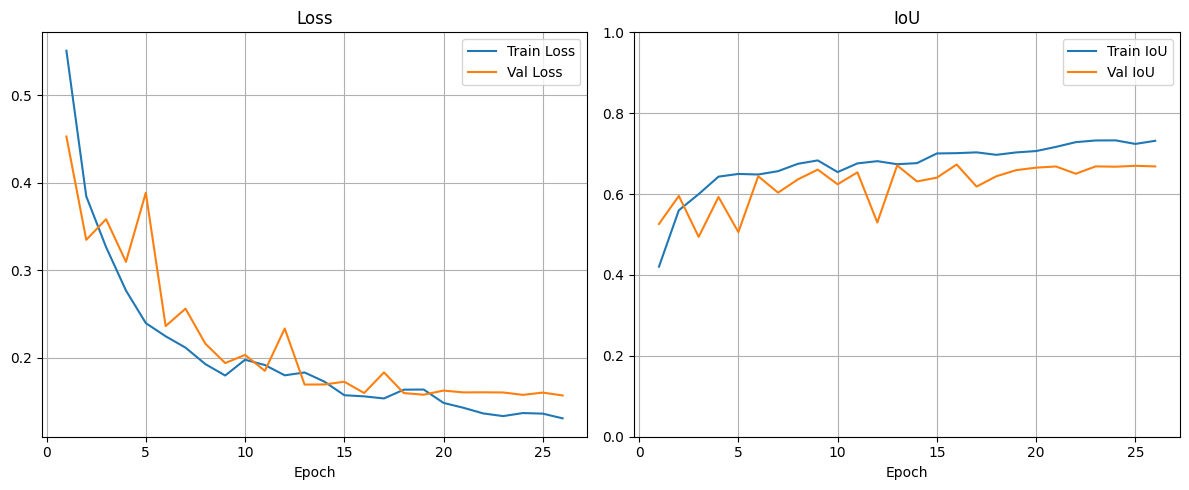

In [24]:
if 'DEVICE' not in locals() or 'NUM_TOTAL_CHANNELS' not in locals():
     print("🛑 Error: Configuration variables not found. Please run Cell 3 first.")
     exit()

if __name__ == "__main__":
    print(f"\n--- Starting Main Execution ---")
    print(f"Using device: {DEVICE}")
    print(f"Checkpoints will be saved in: {CHECKPOINT_DIR}")

    print("\nCreating PyTorch Datasets...")
    try:
        train_dataset = CemsWildfireDataset(
            root_dir=EXTRACTED_TRAIN_DIR,
            band_indices_rasterio=SELECTED_BANDS_RASTERIO,
            selected_bands_zero_based=SELECTED_BANDS_ZERO_BASED,
            albumentations_transform=train_alb_transform,
            s2_norm_factor=S2_NORMALIZATION_FACTOR
        )
        val_dataset = CemsWildfireDataset(
            root_dir=EXTRACTED_VAL_DIR,
            band_indices_rasterio=SELECTED_BANDS_RASTERIO,
            selected_bands_zero_based=SELECTED_BANDS_ZERO_BASED,
            albumentations_transform=val_alb_transform,
            s2_norm_factor=S2_NORMALIZATION_FACTOR
        )
    except (FileNotFoundError, ValueError, RuntimeError, TypeError) as e:
         print(f"\n🛑 Error initializing dataset: {e}")
         print("Please ensure Cell 1 ran, paths are correct, and configs match Dataset args.")
         raise e

    print("\nCreating DataLoaders...")
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS,
        pin_memory=torch.cuda.is_available(), drop_last=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,
        pin_memory=torch.cuda.is_available()
    )
    print(f"DataLoaders ready: Train Batches={len(train_loader)}, Val Batches={len(val_loader)}")

    print(f"\n--- Starting Training for {NUM_EPOCHS} Epochs ---")

    best_val_iou = -1.0
    epochs_no_improve = 0
    training_history = []
    start_time_train = time.time()


    if 'train_one_epoch' not in locals() or 'validate' not in locals():
         print("🛑 Error: train_one_epoch or validate function not defined. Run Cell 8.")
         exit()

    for epoch in range(1, NUM_EPOCHS + 1):
        epoch_start_time = time.time()
        train_loss, train_iou, train_dice = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE, epoch, NUM_EPOCHS)
        val_loss, val_iou, val_dice = validate(model, val_loader, criterion, DEVICE, epoch, NUM_EPOCHS)
        epoch_duration = time.time() - epoch_start_time

        print(f"\nEpoch {epoch}/{NUM_EPOCHS} Summary:")
        print(f"  Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f} | Train Dice: {train_dice:.4f}")
        print(f"  Val Loss:   {val_loss:.4f} | Val IoU:   {val_iou:.4f} | Val Dice:   {val_dice:.4f}")
        print(f"  LR: {optimizer.param_groups[0]['lr']:.1e} | Time: {epoch_duration:.2f}s")

        training_history.append({
            'epoch': epoch, 'train_loss': train_loss, 'train_iou': train_iou, 'train_dice': train_dice,
            'val_loss': val_loss, 'val_iou': val_iou, 'val_dice': val_dice,
            'lr': optimizer.param_groups[0]['lr'], 'time_s': epoch_duration
        })

        scheduler.step(val_iou)
        torch.save(model.state_dict(), LAST_MODEL_PATH)

        if val_iou > best_val_iou:
            best_val_iou = val_iou
            torch.save(model.state_dict(), BEST_MODEL_PATH)
            print(f"  ✨ New Best Model Saved! Val IoU: {best_val_iou:.4f} (Epoch {epoch}) ✨")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"  (Val IoU did not improve from {best_val_iou:.4f}. Patience: {epochs_no_improve}/{EARLY_STOPPING_PATIENCE})")

        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            print(f"\n🛑 Early Stopping triggered after {epoch} epochs.")
            break


    total_training_time = time.time() - start_time_train
    print(f"\n--- Training Finished ---")
    print(f"Total Training Time: {total_training_time / 60:.2f} minutes")
    print(f"Best Validation IoU achieved: {best_val_iou:.4f}")
    print(f"Best model saved to: {BEST_MODEL_PATH}")
    print(f"Last model saved to: {LAST_MODEL_PATH}")


    history_df = pd.DataFrame(training_history)
    history_csv_path = os.path.join(CHECKPOINT_DIR, "training_history.csv")
    history_df.to_csv(history_csv_path, index=False)
    print(f"Training history saved to: {history_csv_path}")
    try:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1); plt.plot(history_df['epoch'], history_df['train_loss'], label='Train Loss'); plt.plot(history_df['epoch'], history_df['val_loss'], label='Val Loss'); plt.title('Loss'); plt.xlabel('Epoch'); plt.legend(); plt.grid(True)
        plt.subplot(1, 2, 2); plt.plot(history_df['epoch'], history_df['train_iou'], label='Train IoU'); plt.plot(history_df['epoch'], history_df['val_iou'], label='Val IoU'); plt.title('IoU'); plt.xlabel('Epoch'); plt.legend(); plt.grid(True); plt.ylim(0, 1)
        plt.tight_layout()
        history_plot_path = os.path.join(CHECKPOINT_DIR, "training_history_plot.png")
        plt.savefig(history_plot_path); print(f"Plot saved to: {history_plot_path}"); plt.show()
    except Exception as plot_err: print(f"Warning: Could not plot history: {plot_err}")

Using existing 'model' variable for inference.
Model is on device: cuda and in evaluation mode.
Fetched a batch of 8 images from val_loader.
Displaying original images, ground truth masks, and predicted masks...


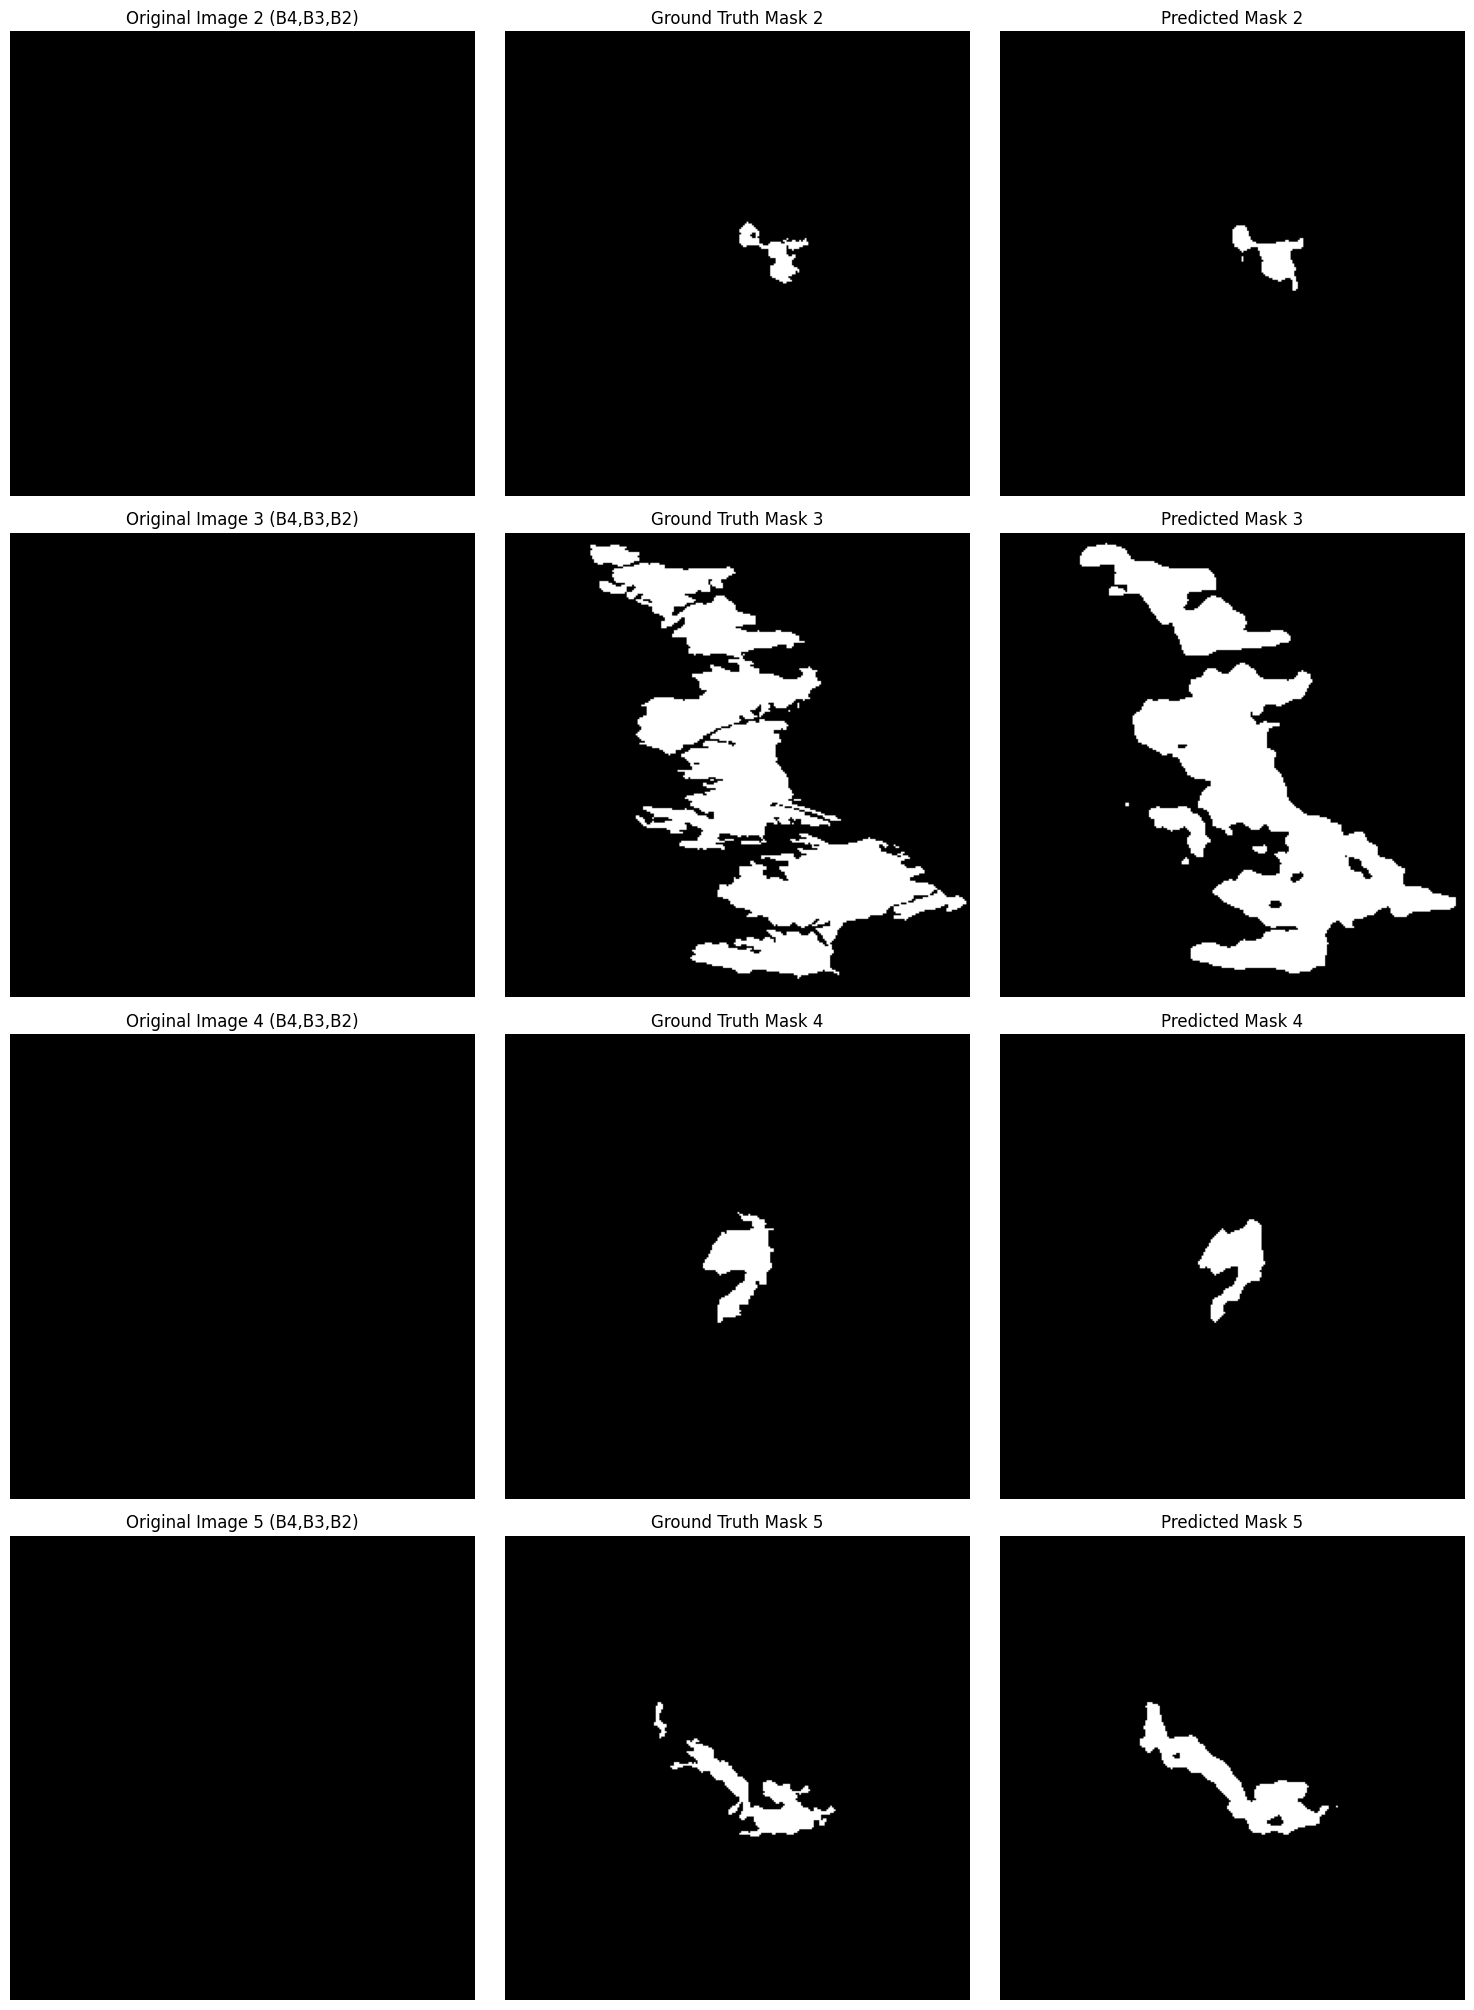

Inference and visualization complete.


In [ ]:
N_CLASSES= 1

NUM_SAMPLES_TO_SHOW = 5

model.to(DEVICE)
model.eval()
print("Model is on device:", DEVICE, "and in evaluation mode.")


try:
    if 'val_loader' not in globals() or val_loader is None:
        print("Warning: 'val_loader' is not defined or is None.")
        print("Attempting to recreate val_loader. Ensure VAL_IMG_DIR, VAL_MASK_DIR, and other necessary params are set.")
        print("If val_loader recreation is attempted, verify its parameters are correct for your setup from Cell 5 and 6.")

    val_iterator = iter(val_loader) 
    images, true_masks = next(val_iterator)
    print(f"Fetched a batch of {images.size(0)} images from val_loader.")

except NameError as e:
    print(f"Error: A required variable for data loading (like 'val_loader', or params for its recreation) is not defined: {e}")
    print("Please ensure all necessary variables from your data setup cells (especially Cell 4, 5, 6, 10) are available.")
    raise
except StopIteration:
    print("Error: Validation data loader is empty. Cannot fetch samples.")
    raise
except Exception as e:
    print(f"An unexpected error occurred while loading data: {e}")
    print("Check your val_loader definition and data paths (EXTRACTED_VAL_DIR etc.).")
    raise


num_to_show_actually = min(NUM_SAMPLES_TO_SHOW, images.size(0))
if num_to_show_actually == 0:
    print("No images loaded, cannot visualize.")
else:
    images = images[:num_to_show_actually]
    true_masks = true_masks[:num_to_show_actually]

    images = images.to(DEVICE, dtype=torch.float32)
    true_masks = true_masks.to(DEVICE, dtype=torch.float32 if N_CLASSES == 1 else torch.long)


   
    with torch.no_grad():
        outputs = model(images)        
        pred_logits = outputs.logits   

        
        pred_logits_resized = nn.functional.interpolate(
            pred_logits,
            size=true_masks.shape[-2:], 
            mode='bilinear',
            align_corners=False
        )

        if N_CLASSES == 1: 
            pred_probs = torch.sigmoid(pred_logits_resized)
            predicted_masks = (pred_probs > 0.5).float()
        else: 
            predicted_masks = torch.argmax(pred_logits_resized, dim=1).unsqueeze(1).float()


    print("Displaying original images, ground truth masks, and predicted masks...")
    plt.figure(figsize=(15, 5 * num_to_show_actually))

    for i in range(1,num_to_show_actually):
        img_np = images[i].cpu().permute(1, 2, 0).numpy()
        display_img_np_rgb = img_np[:, :, [2, 1, 0]] 
        if display_img_np_rgb.min() < 0 or display_img_np_rgb.max() > 1:
             display_img_np_rgb = (display_img_np_rgb - display_img_np_rgb.min()) / (display_img_np_rgb.max() - display_img_np_rgb.min() + 1e-6)
        display_img_np_rgb = np.clip(display_img_np_rgb, 0, 1)


        true_mask_np = true_masks[i].cpu().squeeze().numpy()
        pred_mask_np = predicted_masks[i].cpu().squeeze().numpy()

        plt.subplot(num_to_show_actually, 3, i * 3 + 1)
        plt.imshow(display_img_np_rgb) 
        plt.title(f"Original Image {i+1} (B4,B3,B2)")
        plt.axis('off')

        plt.subplot(num_to_show_actually, 3, i * 3 + 2)
        plt.imshow(true_mask_np, cmap='gray')
        plt.title(f"Ground Truth Mask {i+1}")
        plt.axis('off')

        plt.subplot(num_to_show_actually, 3, i * 3 + 3)
        plt.imshow(pred_mask_np, cmap='gray')
        plt.title(f"Predicted Mask {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
